In [195]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import libraries

In [196]:
# Import libraries and packages
import numpy as np # for array manipulations
import pandas as pd # for reading data/dataframes
import os # for directory
import matplotlib.pyplot as plt # for visualization
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
plt.style.use('seaborn') # Use seaborn style to make visualization prettier

## Read dataset







In [197]:
# Get paths of datasets to be used for EDA
eda_root = '/content/drive/My Drive/lab3'
eda_paths = sorted([os.path.join(eda_root, x) for x in os.listdir(eda_root)])
for path in eda_paths:
    print(path)

/content/drive/My Drive/lab3/codebook.xlsx
/content/drive/My Drive/lab3/test.csv
/content/drive/My Drive/lab3/train.csv


In [198]:
description = pd.read_excel('/content/drive/My Drive/lab3/codebook.xlsx') # read the data
train = pd.read_csv(eda_paths[2]) # read the data
test = pd.read_csv(eda_paths[1]) # read the data

In [199]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [200]:
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324


In [201]:
description.head()

,Variable name,Variable description
0,v2a1,Monthly rent payment
1,hacdor,=1 Overcrowding by bedrooms
2,rooms,number of all rooms in the house
3,hacapo,=1 Overcrowding by rooms
4,v14a,=1 has toilet in the household


##Part 1: Understanding and defining the problem - The goal of this task is to predict the poverty level for each household.


### Q1: Define the machine learning problem of this problem (supervised, unsupervised, binary classification, etc.)
: supervised - Multi class classification

### Q2: Explain the meaning of the target and the categories of the target.

: target is an ordinal variable indicating groups of income levels, total of 4
categories


o 1 = extreme poverty

o 2 = moderate poverty

o 3 = vulnerable households

o 4 = non-vulnerable households


### Q3: Determine what methods can be done to get the prediction for each household, and not for each individual.

: feature중 'parentesco1'의 값이 1이면 한 가정의 가장이므로 query함수를 이용해 train.query('parentesco1==1') 에 대해서만 예측을 실행한다.

### Q4: Some individuals belong to the label "no head of household". Determine what should be done

: train은 진행 하되, test는 진행하지 않는다.

### Q5: Identify the features that seem important just by reading their definitions.

: v2a1 = Monthly rent payment
 
 rooms =  number of all rooms in the house
 
 parentesco1 =1 if household head
 
 meaneduc = average years of education for adults (18+)
 
 overcrowding  = persons per room
 
 tipovivi1 = 1 own and fully paid house
 
 escolari = years of schooling

## Part 2: Data exploration - After reading the train and test data, we have to explore the dataset.

###Q1: Identify the shapes of the train and test dataset.

In [202]:
train.shape, test.shape

((9557, 143), (23856, 142))

### Q2: Identify, print, and explain the distribution of the target in train datasets.

###target is an ordinal variable indicating groups of income levels, total of 4categories

*   1 = extreme poverty
*   2 = moderate poverty
*   3 = vulnerable households
*   4 = non-vulnerable households

In [203]:
train['Target']

0       4
1       4
2       4
3       4
4       4
       ..
9552    2
9553    2
9554    2
9555    2
9556    2
Name: Target, Length: 9557, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


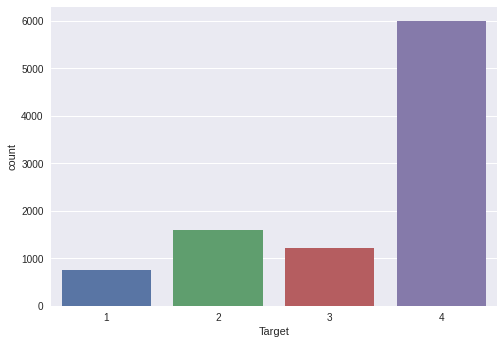

In [204]:
sns.countplot("Target", data=train)

### Q3: Using the important features you selected in the previous section, determine the various distributions and statistics of those selected features. Determine if the results strengthen your selection.

rent_per_person = rent_per_person = v2a1 / hhsize

tablet_per_person = v18q1/hhsize

escolari_age = escolari/age

phone_per_person = qmobilephone/hhsize

(made new feature with improtant feature)

In [205]:
train['rent_per_person'] = train['v2a1']/train['hhsize']
test['rent_per_person'] = test['v2a1']/test['hhsize']

train['tablet_per_person'] = train['v18q1']/train['hhsize']
train['phone_per_person'] = train['qmobilephone']/train['hhsize']
test['tablet_per_person'] = test['v18q1']/test['hhsize']
test['phone_per_person'] = test['qmobilephone']/test['hhsize']

train['escolari_age'] = train['escolari']/train['age']
test['escolari_age'] = test['escolari']/test['age']

In [206]:
# fill "no"s for education with 0s
train.loc[train['edjefa'] == "no", "edjefa"] = 0
train.loc[train['edjefe'] == "no", "edjefe"] = 0
test.loc[test['edjefa'] == "no", "edjefa"] = 0
test.loc[test['edjefe'] == "no", "edjefe"] = 0

# if education is "yes" and person is head of household, fill with escolari
train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "edjefa"] = train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "escolari"]
train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "edjefe"] = train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "escolari"]

test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "edjefa"] = test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "escolari"]
test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "edjefe"] = test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "escolari"]

# this field is supposed to be interaction between gender and escolari, but it isn't clear what "yes" means, let's fill it with 4
train.loc[train['edjefa'] == "yes", "edjefa"] = 4
train.loc[train['edjefe'] == "yes", "edjefe"] = 4

test.loc[test['edjefa'] == "yes", "edjefa"] = 4
test.loc[test['edjefe'] == "yes", "edjefe"] = 4

# convert to int for our models
train['edjefe'] = train['edjefe'].astype("int")
train['edjefa'] = train['edjefa'].astype("int")
test['edjefe'] = test['edjefe'].astype("int")
test['edjefa'] = test['edjefa'].astype("int")

# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toilet, 
# if there is no water we'll assume they do not
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "v14a"] = 0
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "sanitario1"] = 0

test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "v14a"] = 0
test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "sanitario1"] = 0

### Q4: Create a correlation matrix and determine which features are most correlated with the target. Explain and discuss the findings.

In [207]:
correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)
print(f'The most 20 positive feature: \n{correlation.head(20)}')
print('*'*50)

print(f'The most 20 negative feature: \n{correlation.tail(20)}')

The most 20 positive feature: 
Target              1.000000
meaneduc            0.335203
cielorazo           0.304421
escolari            0.302305
phone_per_person    0.298884
SQBescolari         0.296577
eviv3               0.294222
epared3             0.292451
pisomoscer          0.280284
SQBmeaned           0.276620
v2a1                0.273559
paredblolad         0.261274
etecho3             0.257378
rent_per_person     0.247797
SQBedjefe           0.246368
edjefe              0.241139
v18q                0.238864
rooms               0.226208
instlevel8          0.214351
qmobilephone        0.199707
Name: Target, dtype: float64
**************************************************
The most 20 negative feature: 
tamviv            -0.158224
instlevel2        -0.159210
energcocinar4     -0.162366
paredmad          -0.168237
r4m3              -0.173931
epared2           -0.177334
eviv2             -0.179421
etecho1           -0.190837
hacdor            -0.191714
epared1           -0.20302

### Q5: Determine if there are there any possible outliers? (You might have to take a look at all features)


In [208]:
outlier = test['rez_esc']
outlier.value_counts(normalize = True)
# 99 is outlier

0.0     0.776350
1.0     0.119201
2.0     0.056626
3.0     0.028313
4.0     0.012134
5.0     0.007138
99.0    0.000238
Name: rez_esc, dtype: float64

## Part 3: Data preprocessing - This step has to be in continuation with the data exploration step.

### Q1: Determine how the outliers should be handled.

In [209]:
test.loc[test['rez_esc'] == 99.0 , 'rez_esc'] = 5
#결측값이 99였기 때문에 0~5중 가장 큰 값인 5로 대체한다.

### Q2: Explore if there are any missing values in the data.

In [210]:
#check missing values
total = train.isnull().sum().sort_values(ascending=False) # Number of missing value
percent = 100 * (train.isnull().sum() / train.isnull().count()).sort_values(ascending=False) # ratio of missing value
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(10)

,Total,Percent
rez_esc,7928,82.954902
tablet_per_person,7342,76.823271
v18q1,7342,76.823271
rent_per_person,6860,71.779847
v2a1,6860,71.779847
escolari_age,99,1.035890
meaneduc,5,0.052318
SQBmeaned,5,0.052318
public,0,0.000000
sanitario2,0,0.000000


##feature that have missing values

rez_esc : Years behind in school

v18q1 : number of tablets household owns

v2a1 : Monthly rent payment

meaneduc : average years of education for adults (18+)

SQBmeaned : meaned squared

### Q3: Determine how these missing values should be handled.

In [211]:
# Fill with 0 
train['rez_esc'].fillna(0, inplace=True)
test['rez_esc'].fillna(0, inplace=True)

train['meaneduc'].fillna(0, inplace=True)
test['meaneduc'].fillna(0, inplace=True)

train['SQBmeaned'].fillna(0, inplace=True)
test['SQBmeaned'].fillna(0, inplace=True)

train['v2a1'].fillna(0, inplace=True)
test['v2a1'].fillna(0, inplace=True)

def repalce_v18q1(x):
    if x['v18q'] == 0:
        return x['v18q']
    else:
        return x['v18q1']

train['v18q1'] = train.apply(lambda x : repalce_v18q1(x),axis=1)
test['v18q1'] = test.apply(lambda x : repalce_v18q1(x),axis=1)

In [212]:
# Check again
total = train.isnull().sum().sort_values(ascending=False) # Number of missing value
percent = 100 * (train.isnull().sum() / train.isnull().count()).sort_values(ascending=False) # ratio of missing value
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(10)

,Total,Percent
tablet_per_person,7342,76.823271
rent_per_person,6860,71.779847
escolari_age,99,1.035890
abastaguano,0,0.000000
sanitario3,0,0.000000
sanitario2,0,0.000000
sanitario1,0,0.000000
coopele,0,0.000000
noelec,0,0.000000
planpri,0,0.000000


### Q4: Determine if some features need some labelling. Are there any other conversion of representation needed?

Replace object value, because some labels were generated whenever continuous variables have 1 or 0. 

The rule is to have being 1 yes=1 and no=0

### Q5: Determine if some feature engineering can be done and perform them as determined.

#### fill "no"s for education with 0s
train.loc[train['edjefa'] == "no", "edjefa"] = 0

train.loc[train['edjefe'] == "no", "edjefe"] = 0

test.loc[test['edjefa'] == "no", "edjefa"] = 0

test.loc[test['edjefe'] == "no", "edjefe"] = 0

#### if education is "yes" and person is head of household, fill with escolari

train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "edjefa"] = 

train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "escolari"]

train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "edjefe"] = 

train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "escolari"]

In [214]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

escolari_list = ['escolari', 'escolari_age']

for item in escolari_list:
    for function in ['mean','std','min','max','sum']:
        group_train = train[item].groupby(train['idhogar']).agg(function)
        group_test = test[item].groupby(test['idhogar']).agg(function)
        new_col = item + '_' + function
        df_train[new_col] = group_train
        df_test[new_col] = group_test

df_test = df_test.reset_index()
df_train = df_train.reset_index()

In [215]:
train_agg = pd.merge(train, df_train, on='idhogar')
test_ = pd.merge(test, df_test, on='idhogar')

train_agg.fillna(value=0, inplace=True)
test_.fillna(value=0, inplace=True)

In [216]:
train_ = train_agg.query('parentesco1==1')
submission = test_[['Id']]

train_.drop(columns=['idhogar','Id', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test_.drop(columns=['idhogar','Id', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train_.corr()
correlation = correlation['Target'].sort_values(ascending=False)
print(f'The most 20 positive feature: \n{correlation.head(20)}')
print('*'*50)

print(f'The most 20 negative feature: \n{correlation.tail(20)}')

The most 20 positive feature: 
Target               1.000000
escolari_mean        0.423626
escolari_max         0.373091
escolari             0.333791
meaneduc             0.331489
escolari_min         0.306693
cielorazo            0.295249
eviv3                0.293540
epared3              0.280947
escolari_age_min     0.276896
pisomoscer           0.275452
etecho3              0.261142
escolari_age_mean    0.258934
escolari_sum         0.256726
paredblolad          0.254469
edjefe               0.235687
instlevel8           0.235102
escolari_age         0.232205
v18q                 0.230644
phone_per_person     0.223161
Name: Target, dtype: float64
**************************************************
The most 20 negative feature: 
etecho1        -0.209181
r4m1           -0.209479
eviv1          -0.217908
overcrowding   -0.234954
r4t1           -0.260917
hogar_nin      -0.266309
elimbasu5            NaN
estadocivil1         NaN
parentesco1          NaN
parentesco2          NaN
parentes

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Part 4: Machine learning implementation - Once the data has been satisfactorily preprocessed, implement it onto machine learning models.

### Q1: Scale the preprocessed data if needed.

train_.drop(columns=['idhogar','Id', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

test_.drop(columns=['idhogar','Id', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

### Q2: Split the data into train and validation sets

  X_train, X_val = train_.iloc[train_index], train_.iloc[test_index]
  
  y_train, y_val = y.iloc[train_index], y.iloc[test_index]

### Q3: Determine the machine learning models to be used and perform them. (Apply K-Fold cross validation or any other methods to improve the results.)

In [217]:
# Determine the machine learning models to be used and perform
y = train_['Target']

train_.drop(columns=['Target'], inplace=True)

clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.1, objective='multiclass',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 95, num_leaves = 14, subsample = 0.96)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [223]:
# Apply K-Fold cross validation
kfold = 5
kf = StratifiedKFold(n_splits=kfold, shuffle=True)

predicts_result = []
for train_index, test_index in kf.split(train, y):
    print("--------------------------")
    X_train, X_val = train_.iloc[train_index], train_.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=400, verbose=100)
    predicts_result.append(clf.predict(test))

ValueError: ignored

## Part 6: Conclusion

### Q1: Conclude the data science model that you have created.


시간이 부족해서 오류를 해결하지 못해 validation과 테스트를 진행하지 못했습니다.

### Q2: Give thorough discussions

이번 과제는 주어진 가정의 여러가지 feature를 통해서 가난의 척도를 판단하는 모델을 만들고 test하는 것이었다.
먼저 주어진 훈련세트, 데이터세트를 살펴보고 각각의 feature들이 의미하는 바와 Target의 의미를 알아보았다. 이후 missing value, outlier등을 처리하였다. 
모델을 만들때는 LGBE를 이용하였는데 방법에 대한 얕은 이해는 있었으나 각각의 하이퍼 파라미터에 대한 모든 의미를 알지 못했고 그 하이퍼 파라미터를 tuning하는 법에 대해 아직은 잘 알지 못해서 하이퍼 파라미터에 대해서는 구글링을 이용하였다.
